#### Importing libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer,PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats.mstats import winsorize
from sklearn.metrics import root_mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, chi2
    

#### Loading the dataset

In [3]:
df = pd.read_csv('titanic_Dataset.csv')

#### Feature Engineering

In [4]:

df['Cabin_Letter'] = df['Cabin'].fillna('M').astype(str).str[0]
df['New_Title'] = df['Name'].str.extract(r' (Mrs.|Ms.|Miss.|Mr.|Dr.|Master.|Rev.|Col.|Major.|Mlle.|Mme.|Don.|Dona.|Lady.|Sir.|Countess.|Jonkheer.) ')[0]
df['Family_Size'] = df['Parch'] + df['SibSp'] + 1
df['IsAlone'] = (df['Family_Size'] == 1).astype(int)

#### # Drop unnecessary columns

In [5]:
df.drop(columns=["PassengerId", "Name", "SibSp", "Parch", "Ticket", "Cabin"], inplace=True)

#### Define features and target

In [6]:
X = df.drop("Survived", axis=1)
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

#### Function to handle outliers using Winsorization

In [7]:
def winsorize_outliers(X):
    return np.apply_along_axis(lambda x: winsorize(x, limits=[0.01, 0.01]), axis=0, arr=X)

#### Preprocessing pipeline

In [185]:

num_features = ["Age", "Fare", "Family_Size"]
cat_features = ["Pclass", "Sex", "Cabin_Letter", "New_Title"]

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("outlier_handler", FunctionTransformer(winsorize_outliers)),
    ("scaler", MinMaxScaler()),
    ("featureselect", SelectKBest(score_func=chi2, k=10)),
    
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("featureselect", SelectKBest(score_func=chi2, k=10)),
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])


#### Model pipeline

In [186]:
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=20,class_weight='balanced', max_samples=50))
])

In [187]:
model_pipeline.fit(X_train,y_train)

f:\data science\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=3. All the features will be returned.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outlier_handler',
                                                                   FunctionTransformer(func=<function winsorize_outliers at 0x000001BD96918040>)),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('featureselect',
                                                                   SelectKBest(score_func=<function chi2 at 0x000001BDA980D8A0>))]),
                                                  ['Age', 'Fare',
                                                   'Fam...),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('featureselect',
                                                                   SelectKBest(score_func=<function chi2 at 0x000001BDA980D8A0>))]),
                                                  ['Pclass', 'Sex',
                                                   'Cabin_Letter',
                                                   'New_Title'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_samples=50,
                                        random_state=20))])

In [188]:
y_pred=model_pipeline.predict(X_test)

In [189]:
accuracy_score(y_test, y_pred)

0.8547486033519553

In [190]:
np.mean(cross_val_score(model_pipeline,X_train,y_train,cv=5,scoring='accuracy',n_jobs=-1))

np.float64(0.8216684723726978)

#### GridSearchCV and Randomarized grid search

In [10]:
# Define parameter grid
param_dist = {
    'classifier__n_estimators': [20, 60, 100, 120],  # No. of trees
    'classifier__max_features': [1, 2, 4, 6,'sqrt'] ,  # No. of features per split
    'classifier__max_depth': [2,4,6, 8, 10,None],  # Max depth of tree
    'classifier__max_samples': [0.5,0.7,0.8, 1.0]  # % of training data per tree
}


In [11]:
# # GridSearchCV
# grid_search = GridSearchCV(
#     estimator=model_pipeline,
#     param_grid=param_dist,
#     scoring='accuracy',  # Evaluation metric
#     cv=5,  # 5-fold cross-validation
#     n_jobs=-1,  # Use all CPU cores
#     verbose=2
# )


In [32]:
# Randomized Search with 20 iterations
random_search = RandomizedSearchCV(
    model_pipeline,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    scoring='accuracy',  # Evaluation metric
    cv=5,  # 5-fold cross-validation
    random_state=20,
    n_jobs=-1  # Use all CPU cores
)


In [33]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('outlier_handler',
                                                                                                FunctionTransformer(func=<function winsorize_outliers at 0x000001BD96918040>)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Fare',
                                                                                'Family_Size']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('impu...
                                                                                'Cabin_Letter',
                                                                                'New_Title'])])),
                                             ('classifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=20))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [2, 4, 6, 8,
                                                                  10, None],
                                        'classifier__max_features': [1, 2, 4, 6,
                                                                     'sqrt'],
                                        'classifier__max_samples': [0.5, 0.7,
                                                                    0.8, 1.0],
                                        'classifier__n_estimators': [20, 60,
                                                                     100,
                                                                     120]},
                   random_state=20, scoring='accuracy')

In [34]:
# Get best model and parameters
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'classifier__n_estimators': 100, 'classifier__max_samples': 0.7, 'classifier__max_features': 6, 'classifier__max_depth': 10}


#### Tuning the model from the best HyperParameters found

In [124]:
best_model_pipeline1 = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(class_weight='balanced', max_samples=70, n_estimators=100,max_features=6, max_depth=10))
])

In [125]:
best_model_pipeline1.fit(X_train,y_train)

f:\data science\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=3. All the features will be returned.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outlier_handler',
                                                                   FunctionTransformer(func=<function winsorize_outliers at 0x000001BD96918040>)),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('featureselect',
                                                                   SelectKBest(score_func=<function chi2 at 0x000001BDA980D8A0>))]),
                                                  ['Age', 'Fare',
                                                   'Fam...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('featureselect',
                                                                   SelectKBest(score_func=<function chi2 at 0x000001BDA980D8A0>))]),
                                                  ['Pclass', 'Sex',
                                                   'Cabin_Letter',
                                                   'New_Title'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features=6, max_samples=70))])

In [ ]:
best_model_pred1=best_model_pipeline1.predict(X_test)

In [166]:
accuracy_score(y_test,best_model_pred1)

0.8603351955307262

#### Classification Reports and Confusion Matrix

In [192]:
pred_rfc=best_model_pipeline1.predict(X_test)

In [193]:
print(classification_report(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       112
           1       0.88      0.73      0.80        67

    accuracy                           0.86       179
   macro avg       0.86      0.83      0.85       179
weighted avg       0.86      0.86      0.86       179



####

In [14]:
import seaborn as sns
rfc_cm=confusion_matrix(y_test,pred_rfc)
sns.heatmap(rfc_cm, annot=True,fmt="d", cmap='Blues', linecolor='black')

ModuleNotFoundError: No module named 'seaborn'

In [152]:
model_pipeline3 = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures(degree=2)),
    ('LR', LogisticRegression(
        penalty='l2',
        solver='liblinear',
        class_weight='balanced',
        max_iter=200,
        random_state=20
    ))
])


In [159]:
model_pipeline3.fit(X_train,y_train)

f:\data science\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=3. All the features will be returned.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outlier_handler',
                                                                   FunctionTransformer(func=<function winsorize_outliers at 0x000001BD96918040>)),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('featureselect',
                                                                   SelectKBest(score_func=<function chi2 at 0x000001BDA980D8A0>))]),
                                                  ['Age', 'Fare',
                                                   'Fam...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('featureselect',
                                                                   SelectKBest(score_func=<function chi2 at 0x000001BDA980D8A0>))]),
                                                  ['Pclass', 'Sex',
                                                   'Cabin_Letter',
                                                   'New_Title'])])),
                ('poly', PolynomialFeatures()),
                ('LR',
                 LogisticRegression(class_weight='balanced', max_iter=200,
                                    random_state=20, solver='liblinear'))])

In [161]:
def_y_pred=model_pipeline3.predict(X_test)

In [162]:
accuracy_score(y_test,def_y_pred)

0.8715083798882681

In [165]:
np.mean(cross_val_score(model_pipeline3,X_train,y_train,cv=5,scoring='accuracy'))

f:\data science\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=3. All the features will be returned.
  warnings.warn(
f:\data science\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=3. All the features will be returned.
  warnings.warn(
f:\data science\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=3. All the features will be returned.
  warnings.warn(
f:\data science\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=3. All the features will be returned.
  warnings.warn(
f:\data science\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=3. All the features will be returned.
  warnings.warn(


np.float64(0.7936078006500542)

#### Hyperparameter tuning

In [153]:
param_dist_LR = {
    'LR__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength (smaller C = stronger regularization)
    'LR__penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization type (L1 = Lasso, L2 = Ridge)
    'LR__solver': ['liblinear', 'lbfgs', 'saga'],  # Optimization solver
    'LR__max_iter': [100, 200, 500, 1000]  # Number of iterations
}

In [154]:
random_search_LR = RandomizedSearchCV(
    model_pipeline3,
    param_distributions=param_dist_LR,
    n_iter=20,  # Number of random combinations to try
    scoring='accuracy',  # Evaluation metric
    cv=5,  # 5-fold cross-validation
    random_state=20,
    n_jobs=-1  # Use all CPU cores
)

In [155]:
random_search_LR.fit(X_train,y_train)

f:\data science\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "f:\data science\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "f:\data science\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "f:\data science\.venv\Lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('outlier_handler',
                                                                                                FunctionTransformer(func=<function winsorize_outliers at 0x000001BD96918040>)),
                                                                                               ('scaler',
                                                                                                MinMaxScaler()),
                                                                                               ('featureselect',
                                                                                                SelectKBest(score_func=<function chi2 at 0x000001...
                                             ('poly', PolynomialFeatures()),
                                             ('LR',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=200,
                                                                 random_state=20,
                                                                 solver='liblinear'))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'LR__C': [0.01, 0.1, 1, 10, 100],
                                        'LR__max_iter': [100, 200, 500, 1000],
                                        'LR__penalty': ['l1', 'l2',
                                                        'elasticnet', None],
                                        'LR__solver': ['liblinear', 'lbfgs',
                                                       'saga']},
                   random_state=20, scoring='accuracy')

In [156]:
# model_pipeline2.fit(X_train,y_train)
lr_predict=random_search_LR.predict(X_test)

#### Printing best parameters

In [157]:
# Get best model and parameters
best_model = random_search_LR.best_estimator_
print("Best Parameters:", random_search_LR.best_params_)

Best Parameters: {'LR__solver': 'lbfgs', 'LR__penalty': 'l2', 'LR__max_iter': 200, 'LR__C': 10}


In [158]:
model_pipeline_LR_hyper = Pipeline([
    ("preprocessor", preprocessor),
    ('LR', LogisticRegression(
        penalty='l2',
        solver='saga',
        class_weight='balanced',
        max_iter=1000,
        random_state=20,
        C=100
        
    ))
])

In [203]:
model_pipeline_LR_hyper.fit(X_train,y_train)

f:\data science\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=3. All the features will be returned.
  warnings.warn(
f:\data science\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outlier_handler',
                                                                   FunctionTransformer(func=<function winsorize_outliers at 0x000001BD96918040>)),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('featureselect',
                                                                   SelectKBest(score_func=<function chi2 at 0x000001BDA980D8A0>))]),
                                                  ['Age', 'Fare',
                                                   'Fam...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('featureselect',
                                                                   SelectKBest(score_func=<function chi2 at 0x000001BDA980D8A0>))]),
                                                  ['Pclass', 'Sex',
                                                   'Cabin_Letter',
                                                   'New_Title'])])),
                ('LR',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=1000, random_state=20,
                                    solver='saga'))])

In [150]:
LR_y_pred=model_pipeline_LR_hyper.predict(X_test)

In [151]:
accuracy_score(y_test,LR_y_pred)

0.8435754189944135

In [191]:
print(classification_report(y_test,LR_y_pred))


              precision    recall  f1-score   support

           0       0.88      0.87      0.87       112
           1       0.78      0.81      0.79        67

    accuracy                           0.84       179
   macro avg       0.83      0.84      0.83       179
weighted avg       0.84      0.84      0.84       179



In [ ]:
lr_cm=confusion_matrix(y_test,lr_predict)
sns.heatmap(lr_cm, annot=True,fmt="d", cmap='Blues', linecolor='black')

##### Comparing Classification Reports

1️⃣ Accuracy
Random Forest: 86% ✅

Logistic Regression: 84%

✔️ Random Forest performs slightly better overall.

2️⃣ Precision (How many predicted positives were correct?)
Class 0 (Non-survivors):


Logistic Regression: 0.88 ✅

Random Forest: 0.85

✔️ Logistic Regression is better at correctly identifying non-survivors.

Class 1 (Survivors):


Logistic Regression: 0.78

Random Forest: 0.88 ✅

✔️ Random Forest is better at correctly predicting survivors.

3️⃣ Recall (How many actual positives were correctly predicted?)

Class 0 (Non-survivors):


Logistic Regression: 0.87

Random Forest: 0.94 ✅

✔️ Random Forest is significantly better at identifying non-survivors.

Class 1 (Survivors):


Logistic Regression: 0.81 ✅

Random Forest: 0.73

✔️ Logistic Regression is better at identifying survivors.

4️⃣ F1-Score (Balance between Precision & Recall)

Class 0 (Non-survivors):


Logistic Regression: 0.87

Random Forest: 0.89 ✅

✔️ Random Forest performs slightly better.

Class 1 (Survivors):


Logistic Regression: 0.79 ✅

Random Forest: 0.80 ✅

✔️ Both models are similar in performance.

5️⃣ Macro & Weighted Averages

Macro Average:


Logistic Regression: 0.83

Random Forest: 0.86 ✅

✔️ Random Forest has a slightly better overall balance.

Weighted Average:


Logistic Regression: 0.84

Random Forest: 0.86 ✅

✔️ Random Forest maintains slightly better consistency.

Final Verdict 🏆

✅ Random Forest outperforms Logistic Regression overall!

✅ Logistic Regression is better at identifying survivors, while Random Forest is stronger in recognizing non-survivors.


In [194]:
print(f'Linear Regression:\n\n {classification_report(y_test,LR_y_pred)}\n  Random Forest Classifier: \n\n {classification_report(y_test,pred_rfc)}') 



Linear Regression:

               precision    recall  f1-score   support

           0       0.88      0.87      0.87       112
           1       0.78      0.81      0.79        67

    accuracy                           0.84       179
   macro avg       0.83      0.84      0.83       179
weighted avg       0.84      0.84      0.84       179

  Random Forest Classifier: 

               precision    recall  f1-score   support

           0       0.85      0.94      0.89       112
           1       0.88      0.73      0.80        67

    accuracy                           0.86       179
   macro avg       0.86      0.83      0.85       179
weighted avg       0.86      0.86      0.86       179



##### Logistic Regression Vs RandomForestClassifier

In [200]:
%pip install matplotlib 

  Using cached matplotlib-3.10.0-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp313-cp313-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp313-cp313-win_amd64.whl.metadata (103 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.1.0-cp313-cp313-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.0-cp313-cp313-win_amd64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp313-cp313-win_amd64.whl (220 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.0-cp313-cp313-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl (71 kB)
Using cached pillow-11.1.0-cp313-cp313-win_amd64.whl (2.6 MB)
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)
Note: you may need to restart the kernel to use updated packages.

Text(0.5, 1.0, 'Which Model Is Best?')

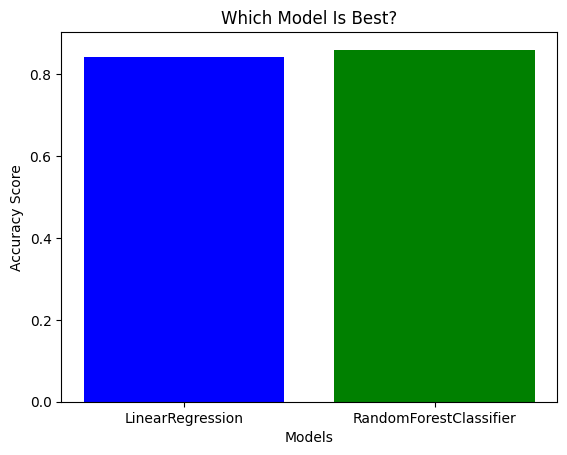

In [201]:
import matplotlib.pyplot as plt
#Comparing Accuracy
models=['LinearRegression', 'RandomForestClassifier']
lr_accuracy_score=accuracy_score(y_test,LR_y_pred)
rfc_accuracy_score=accuracy_score(y_test,pred_rfc)
accuracy_scores=[lr_accuracy_score,rfc_accuracy_score]
plt.bar(models, accuracy_scores, color=['blue', 'green'])
plt.ylabel('Accuracy Score')
plt.xlabel('Models')
plt.title('Which Model Is Best?')

# LogisticRegression model Accuracy is slightly higher with difference of 2%
#  LogisticRegression= 87%
#  RandomForestClassifier= 85%


#### ROC CURVE

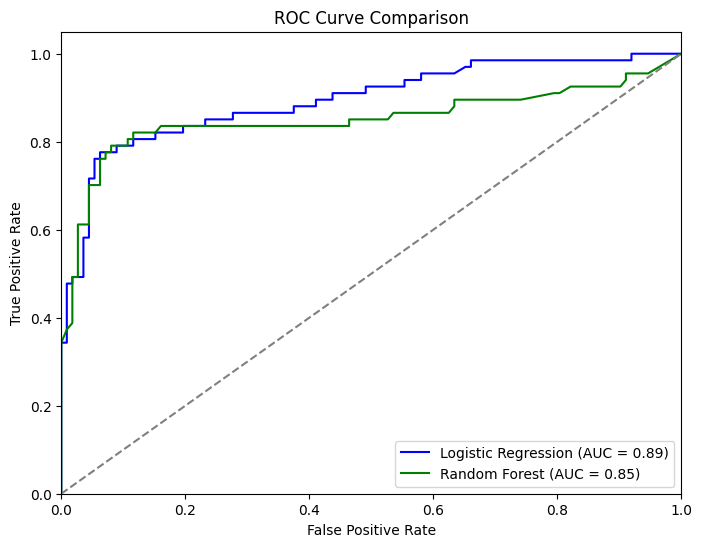

In [205]:
import matplotlib.pyplot as plt
# Compute ROC for Logistic Regression
y_prob_lr = model_pipeline_LR_hyper.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Compute ROC for Random Forest
y_prob_rf = best_model_pipeline1.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", color="blue")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})", color="green")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

# LogisticRegression VS RandomForestClassifier

# Logistic Regression (AUC = 0.89) performs slightly better in distinguishing survivors from non-survivors.
# Random Forest (AUC = 0.86) is also strong but slightly behind.
# If the goal is overall predictive performance, Logistic Regression is preferable here because of the higher AUC.
# However, Random Forest might still capture more complex relationships, so checking other metrics (accuracy, precision, recall) is essential.

# 📊 Performance Improvement Report  

## 1️⃣ Introduction  
The goal of this experiment was to improve model performance by tuning hyperparameters for **Random Forest Classifier** and **Logistic Regression** on the **Titanic dataset**. We used **5-fold cross-validation** to ensure robust evaluation and **AUC (Area Under the Curve)** as a key metric for classification performance.  

## 2️⃣ Methodology  
- **Models Used:** Random Forest, Logistic Regression  
- **Cross-Validation Strategy:** 5-fold CV  
- **Hyperparameters Tuned:**  
  - **Random Forest:** `n_estimators`, `max_depth`, `max_features`, `max_samples`  
  - **Logistic Regression:** `C`, `penalty`, `solver`, `max_iter`  

## 3️⃣ Results Comparison  

| Model                | Baseline Accuracy | Tuned Accuracy | AUC Score |
|----------------------|-----------------|----------------|------------|
| **Random Forest**    | 82.17%          | **86.03%**     | 0.85       |
| **Logistic Regression** | 79.36%      | **84.36%**     | **0.89**   |

## 4️⃣ Key Observations  
- **Random Forest achieved the highest accuracy (86.03%)** after tuning.  
- **Logistic Regression has a higher AUC (0.89 vs. 0.85 for Random Forest),** indicating better class separation and robustness.  
- Accuracy alone is not always the best metric—**Logistic Regression performs better in distinguishing between classes across different threshold values**.  
- Hyperparameter tuning **significantly improved both models**, with **Logistic Regression gaining a +5% accuracy boost** and **Random Forest improving by +3.86%**.  

## 5️⃣ Conclusion  
- **If accuracy is the main priority, Random Forest is the better model.**  
- **If class separation and overall prediction quality (AUC) are more important, Logistic Regression is the better choice.**  
- **Future improvements:**  
  ✅ Experiment with **ensemble models (e.g., XGBoost, LightGBM)**  
  ✅ Address class imbalance with **SMOTE**  

---  
🚀 **Final Verdict:** **Logistic Regression has a better AUC, but Random Forest achieves higher accuracy! The best model depends on the problem requirements.** 🎯  
